In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
# from sklearn.compose import ColumnTransformer, make_column_transformer
# from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor
# from sklearn.impute import SimpleImputer
# from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.model_selection import (
    KFold,
    cross_val_score,
    train_test_split,
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb
%pip install shap
import shap

  Using cached shap-0.47.1-cp312-cp312-win_amd64.whl.metadata (25 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
Using cached shap-0.47.1-cp312-cp312-win_amd64.whl (490 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Using cached cloudpickle-3.1.1-py3-none-any.whl (20 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
## Loading the data
data = pd.read_csv("data/result.csv")
## DC,Washington,601723,1150000,20.3,18,20.5,25.4,35.2,51

In [ ]:
## Checking if data is valid
print(data.head())
data.shape

  State   CityName  Population2010  cityfips  BingeDrinking  SmokingRate  \
0    GA     Albany           77434   1301052           10.9         23.7   
1    TX   Amarillo          190695   4803000           16.5         18.5   
2    AK  Anchorage          291826    203000           20.2         18.3   
3    GA    Atlanta          420003   1304000           14.1         16.6   
4    GA    Augusta          195844   1304204           12.5         21.8   

   NoPhysicalActivity  ObesityRate  SleepDeprivation  GeoCode  Cancer  \
0                33.1         40.4              46.9      525      76   
1                27.9         32.0              32.9      634      67   
2                19.2         27.7              33.4      743      62   
3                22.4         31.6              40.4      524      72   
4                28.1         36.0              44.1      520      69   

   Cardiovascular  Depression  Diabetes  Diarrhea  Obesity  Rehab  Stroke  \
0              71          

(80, 19)

## Data Preparation

Since we want to predict cardiovascular search trends using health behaviors, they are loaded as target and features respectively.

In [13]:
features = ['BingeDrinking', 'SmokingRate', 'NoPhysicalActivity', 'ObesityRate', 'SleepDeprivation']
target = 'Cardiovascular'

X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Effectiveness of using county-level health behaviors to predict cardiovascular related search trends

Using RMSE score during 5-fold cross validation to assess the four model's effectiveness.

In [ ]:
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "kNN": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0)
}

# Train and evaluate
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate models
for name, model in models.items():
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    rmse_scores = -cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    
    print(f"{name}:")
    print(f"  RMSE: Mean = {rmse_scores.mean():.4f}, Std = {rmse_scores.std():.4f}\n")

print(f"Mean Cardiovascular Search Score = {y.mean()}\n")

Decision Tree:
  R²:   Mean = -0.9197, Std = 0.5052
  RMSE: Mean = 14.6019, Std = 3.0838

kNN:
  R²:   Mean = -0.4199, Std = 0.1680
  RMSE: Mean = 12.8598, Std = 3.4223

Random Forest:
  R²:   Mean = -0.3130, Std = 0.1615
  RMSE: Mean = 12.4677, Std = 3.8316

XGBoost:
  R²:   Mean = -0.2758, Std = 0.3252
  RMSE: Mean = 12.2593, Std = 4.3964

Mean Cardiovascular Search Score = 43.0375



## Result Analysis

The result of the 4 models are mostly similar, where decision tree has a RMSE 14, while kNN, Random Forest, and XGBoost are all around 12. XGBoost is the best performing model with an RMSE of 12.2593. This implies that the average distance between predicted values and actual values is 12.2593. This is not a great result since the Percentage Error is around 27%, and a good model should have less than 10% error. However, we believe this model would do much better given a larger dataset, as there are only 80 observations in our data.

#### Health behaviors with the greatest impact on cardiovascular related search trends

The following are code used to conduct shap analysis on our best performing model XGBoost.

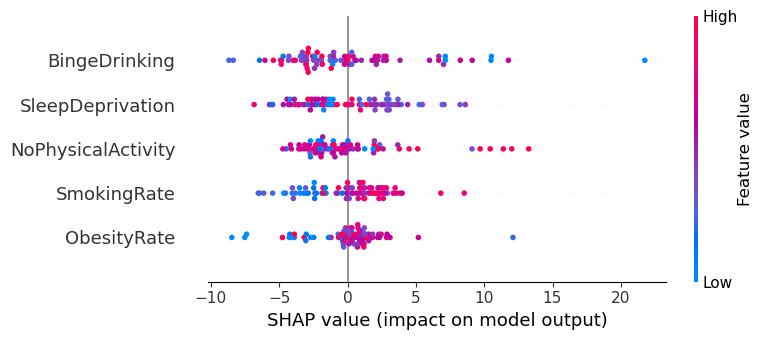

              Feature  Mean |SHAP value|
0       BingeDrinking           3.580634
4    SleepDeprivation           2.869061
2  NoPhysicalActivity           2.610257
1         SmokingRate           2.311447
3         ObesityRate           1.755667


In [21]:
# Train XGBoost model
model = xgb.XGBRegressor(random_state=42, verbosity=0)
model.fit(X, y)

# Explain with SHAP
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Plot summary (feature importance + direction)
shap.summary_plot(shap_values, X)
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Put into a DataFrame for readability
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Mean |SHAP value|': shap_importance
}).sort_values(by='Mean |SHAP value|', ascending=False)

print(importance_df)

## Result Analysis

From the results above, BingeDrinking had a surprising effect on cardiovascular search trend predictions, having a feature importance score of 3.58, much higher than the two following features SleepDeprivation and NoPhysicalActivity, with a importance score of 2.86 and 2.61 respectively. Interestingly, ObesityRate has by far the lowest importance score, meaning ObesityRate does not have a great impact on cardiovascular related searches, even though it is considered the leading cause of cardiovascular diseases.